# Importing The Libraries

In [ ]:
import numpy as np
import os
import seaborn as sn;
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization,Input, Rescaling, Resizing
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings(action='ignore')

# Loading The DataSet

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/Potato_Leaf_Disease",
    seed=58,
    shuffle=True,
    image_size=(256,256),
    batch_size=32
)

Found 3076 files belonging to 7 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']

# Visualizing The Data

In [ ]:
def get_all_labels(ds):
    labels = []
    for image_batch, labels_batch in ds:
        labels.extend(labels_batch.numpy())
    return labels

In [ ]:
labels = get_all_labels(dataset)
# Count the occurrences of each class
class_counts = {class_name: 0 for class_name in class_names}
for label in labels:
    class_counts[class_names[label]] += 1


In [ ]:
# Plot the pie chart
import plotly.express as px
import pandas as pd
df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
fig = px.pie(df, values='Count', names='Class',width=550, height=550)
fig.show()

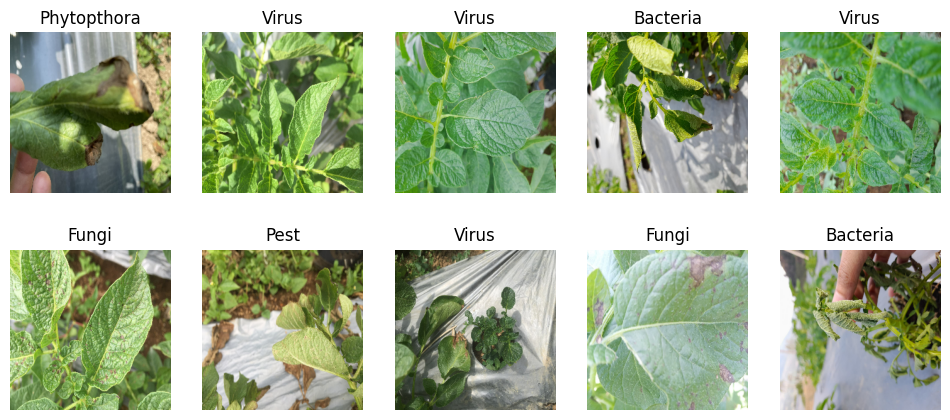

In [ ]:
plt.figure(figsize=(12,8))
for image_batch, labels_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


# Function to Split Dataset

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)


    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))
print(len(dataset))

77
9
11
97


In [ ]:

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
from tensorflow.keras import layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1./255),
])


# Modeling

In [ ]:
input_shape = (32,256,256,3)
def model(input_shape):
    base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=input_shape[1:])
    base_model.trainable = False

    model = Sequential([
        base_model,
        BatchNormalization(),
        Flatten(),
        Dense(264, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(64, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(7, activation='softmax')
    ])

    return model

# Create the model
model = model(input_shape)
model.build(input_shape=input_shape)
model.summary()


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-s (Functional)        │ (32, 8, 8, 1280)            │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 8, 8, 1280)            │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 81920)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 264)                   │      21,627,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 264)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 264)                   │           1,056 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 128)                   │          33,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (32, 128)                   │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (32, 64)                    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 7)                     │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,008,079 (160.25 MB)

 Trainable params: 21,673,247 (82.68 MB)

 Non-trainable params: 20,334,832 (77.57 MB)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras import mixed_precision

# Disable XLA
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'

# Use float32 precision
mixed_precision.set_global_policy('float32')

In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'


In [ ]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 156s 981ms/step - accuracy: 0.2206 - loss: 2.2968 - val_accuracy: 0.5417 - val_loss: 1.2871
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.3897 - loss: 1.6599 - val_accuracy: 0.6597 - val_loss: 1.0064
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.5169 - loss: 1.2950 - val_accuracy: 0.7118 - val_loss: 0.8316
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.6022 - loss: 1.0938 - val_accuracy: 0.7674 - val_loss: 0.6742
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 122ms/step - accuracy: 0.6690 - loss: 0.9327 - val_accuracy: 0.8056 - val_loss: 0.5863
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.7194 - loss: 0.8207 - val_accuracy: 0.8507 - val_loss: 0.4522
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.7658 - loss: 0.6936 - val_accuracy: 0.8715 - val_loss: 0.4090
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.7929 - loss: 0.6042 - val_accur

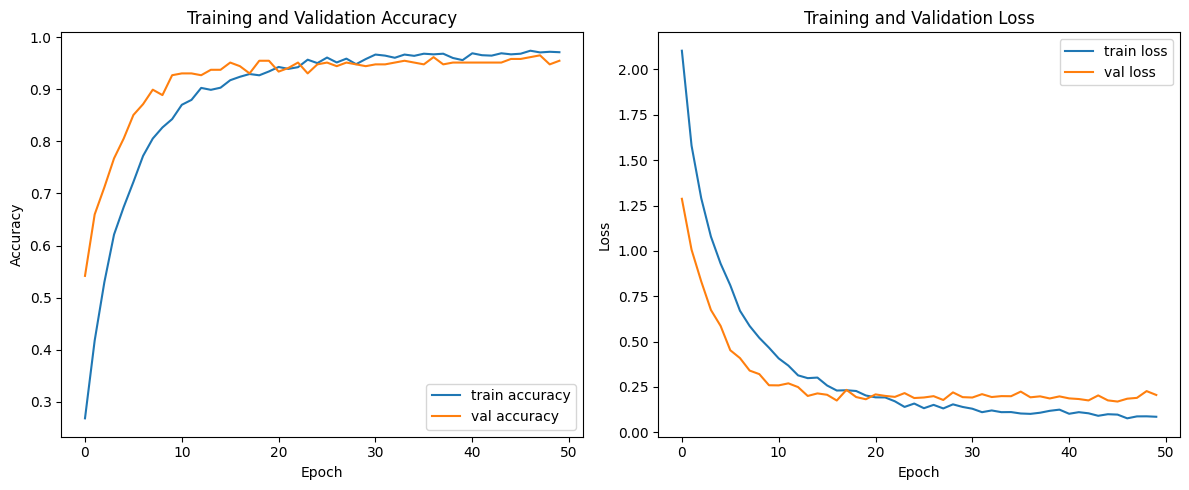

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust figsize as needed

# Plot accuracy on the first subplot
axes[0].plot(history.history['accuracy'], label='train accuracy')
axes[0].plot(history.history['val_accuracy'], label='val accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Training and Validation Accuracy')

# Plot loss on the second subplot
axes[1].plot(history.history['loss'], label='train loss')
axes[1].plot(history.history['val_loss'], label='val loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].set_title('Training and Validation Loss')

# Adjust layout and display the figure
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model on the validation data
evaluation = model.evaluate(val_ds)

# Print the evaluation metrics
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9578 - loss: 0.2221
Validation Loss: 0.2055540382862091
Validation Accuracy: 0.9548611044883728


# Around 95.5% validation accuracy.